In [1]:
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torchviz import make_dot, make_dot_from_trace

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Data and Preprocessing
Download training and test data, normalize to between [0, 1]

In [3]:
# Download training data from open datasets.
# ToTensor() automatically normalizes the image between 0 and 1
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
# ToTensor() automatically normalizes the image between 0 and 1
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


### CNN Model 1:
* 28x28x1 Input (Grayscale Image)
* Convolution Layer 1 (1 input channel, 10 output channels, kernel size 5x5)
* Max Pooling Layer (2x2)
* Convolution Layer 2 (10 input channels, 32 output channels, kernel size 3x3)
* Fully Connected Layer 1 (800 input features, 120 output features)
* Fully Connected Layer 2 (120 input features, 84 output features)
* Fully connected Layer 3 (84 input features, 10 output features (the predicted class))
* Optimizer: Adam

In [5]:
# Convolutional Neural Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 32, 3)
        self.fc1 = nn.Linear(800, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [20]:
loss_values_1 = []
for epoch in range(10):  # loop over the dataset multiple times
    print("Epoch: " + str(epoch + 1))

    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    loss_values_1.append(total_loss / len(train_dataloader))

print('Finished Training')

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Finished Training


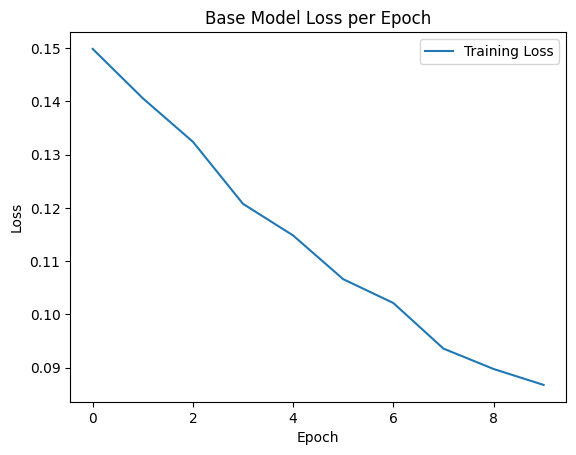

In [38]:
plt.plot(loss_values_1, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Base Model Loss per Epoch')
plt.legend()
plt.show()

### Base Model Performance on Test Set

Accuracy of the network on the 10000 test images: 88 %


<Axes: >

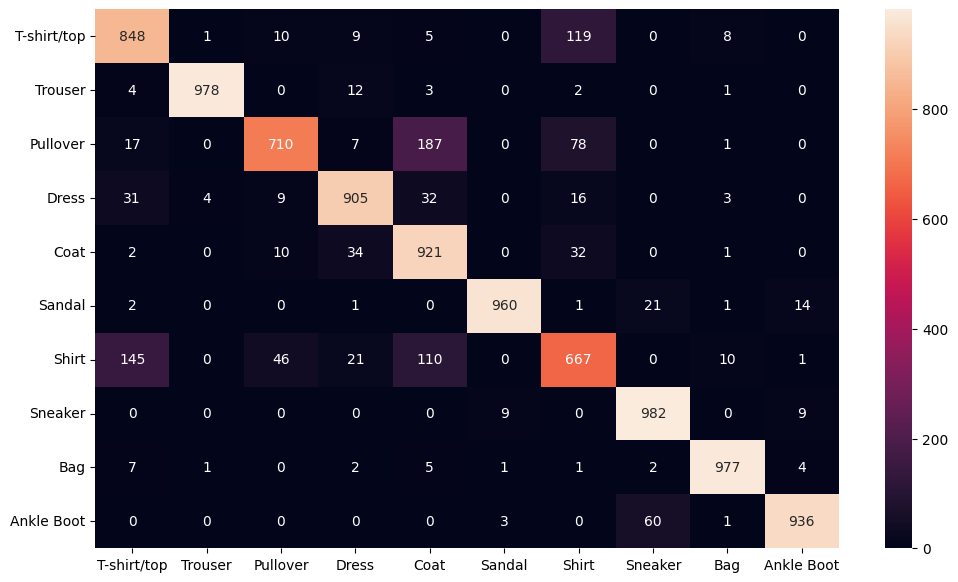

In [8]:
correct = 0
total = 0
y_pred_1 = []
y_true_1 = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest probability is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred_1.extend(predicted.data.cpu().numpy())
        y_true_1.extend(labels.data.cpu().numpy())


cf_matrix_1 = confusion_matrix(y_true_1, y_pred_1)

cf_matrix_dataframe_1 = pd.DataFrame(cf_matrix_1, index = [i for i in classes],
                     columns = [i for i in classes])

# Dummy input for graph, requires_grad = True to see full visualization
graph_random_input = torch.randn(1, 1, 28, 28, requires_grad=True)
# Dummy output for graph
graph_random_output = net(graph_random_input)
make_dot(graph_random_output, params=dict(list(net.named_parameters()))).render("net_graph", format="png")
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

plt.figure(figsize = (12,7))
sns.heatmap(cf_matrix_dataframe_1, annot=True, fmt='g')

### CNN Model 2:
* 28x28x1 Input (Grayscale Image)
* Convolution Layer 1 (1 input channel, 10 output channels, kernel size 5x5)
* Batch Normalization 1 (10 input features)
* Max Pooling Layer (2x2)
* Convolution Layer 2 (10 input channels, 32 output channels, kernel size 3x3)
* Batch Normalization 2 (32 input features)
* Max Pooling Layer (2x2)
* Convolution Layer 3 (32 input channels, 32 output channels) 
* Dropout Layer (50% chance of dropping a neuron)
* Fully Connected Layer 1 (32 input features, 120 output features)
* Fully Connected Layer 2 (120 input features, 84 output features)
* Fully connected Layer 3 (84 input features, 10 output features (the predicted class))
* Optimizer: Adam

In [9]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 8)
        self.bn1 = nn.BatchNorm2d(10)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.fc1 = nn.Linear(32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net2 = Net2()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(net2.parameters(), lr=0.001)

In [31]:
loss_values_2 = []
for epoch in range(10):  # loop over the dataset multiple times
    print("Epoch: " + str(epoch + 1))

    running_loss2 = 0.0
    total_loss2 = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer2.zero_grad()

        # Forward + backward + optimize
        outputs2 = net2(inputs)
        loss2 = criterion2(outputs2, labels)
        loss2.backward()
        optimizer2.step()

        # Print statistics
        running_loss2 += loss2.item()
        total_loss2 += loss2.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss2 / 2000:.3f}')
            running_loss2 = 0.0
    loss_values_2.append(total_loss2 / len(train_dataloader))
print('Finished Training')

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Finished Training


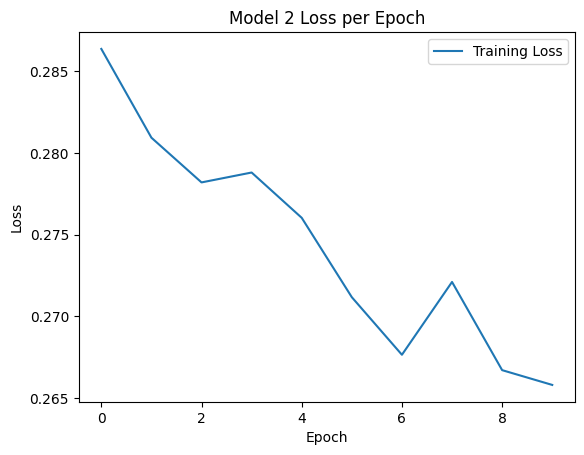

In [37]:
plt.plot(loss_values_2, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss per Epoch')
plt.legend()
plt.show()

### Modified Model 1 Performance on Test Set

Accuracy of the network on the 10000 test images: 86 %


<Axes: >

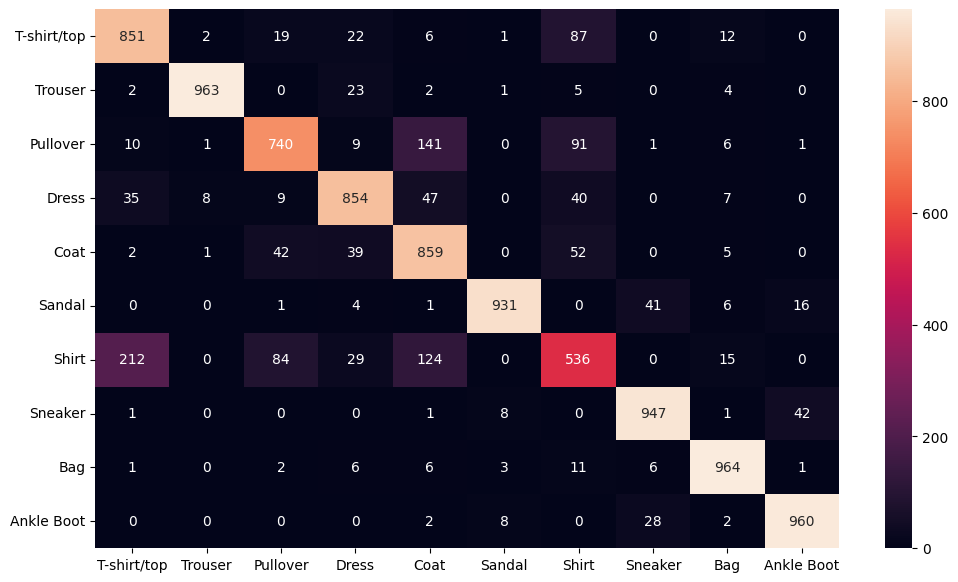

In [24]:
correct2 = 0
total2 = 0
y_pred_2 = []
y_true_2 = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total2 += labels.size(0)
        correct2 += (predicted == labels).sum().item()
        y_pred_2.extend(predicted.data.cpu().numpy())
        y_true_2.extend(labels.data.cpu().numpy())
print(f'Accuracy of the network on the 10000 test images: {100 * correct2 // total2} %')

cf_matrix_2 = confusion_matrix(y_true_2, y_pred_2)

cf_matrix_dataframe_2 = pd.DataFrame(cf_matrix_2, index = [i for i in classes],
                     columns = [i for i in classes])

# Dummy input for graph, requires_grad = True to see full visualizaiton
graph_random_input = torch.randn(1, 1, 28, 28, requires_grad=True)
# Dummy output for graph
graph_random_output = net2(graph_random_input)
make_dot(graph_random_output, params=dict(list(net2.named_parameters()))).render("net_graph2", format="png")

plt.figure(figsize = (12,7))
sns.heatmap(cf_matrix_dataframe_2, annot=True, fmt='g')

### CNN Model 3:
* 28x28x1 Input (Grayscale Image)
* Convolution Layer 1 (1 input channel, 10 output channels, kernel size 7x7)
* Max Pooling Layer (2x2)
* Convolution Layer 2 (10 input channels, 32 output channels, kernel size 4x4)
* Dropout Layer (25% of dropping a neuron)
* Fully Connected Layer 1 (2048 input features, 120 output features)
* Fully Connected Layer 2 (120 input features, 84 output features)
* Fully connected Layer 3 (84 input features, 10 output features (the predicted class))
* Optimizer: Adam

In [25]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 32, 4)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net3 = Net3()
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(net3.parameters(), lr=0.001)

In [26]:
loss_values_3 = []
for epoch in range(10):  # loop over the dataset multiple times
    print("Epoch: " + str(epoch + 1))

    running_loss3 = 0.0
    total_loss3 = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer3.zero_grad()

        # Forward + backward + optimize
        outputs3 = net3(inputs)
        loss3 = criterion3(outputs3, labels)
        loss3.backward()
        optimizer3.step()

        # Print statistics
        running_loss3 += loss3.item()
        total_loss3 += loss3.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss2 / 2000:.3f}')
            running_loss3 = 0.0
    loss_values_3.append(total_loss3 / len(train_dataloader))
print('Finished Training')

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Finished Training


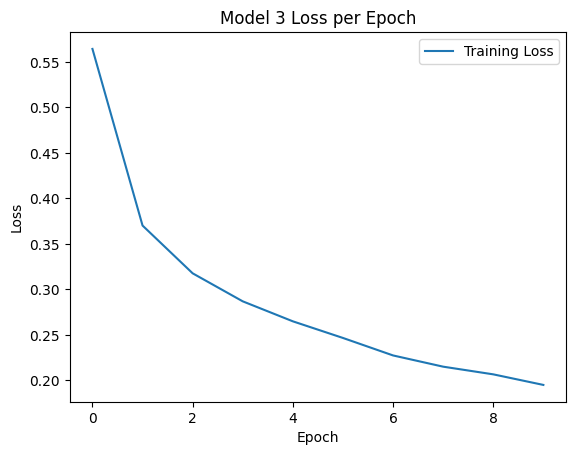

In [36]:
plt.plot(loss_values_3, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss per Epoch')
plt.legend()
plt.show()

### Modified Model 3 Performance on Test Set

Accuracy of the network on the 10000 test images: 88 %


<Axes: >

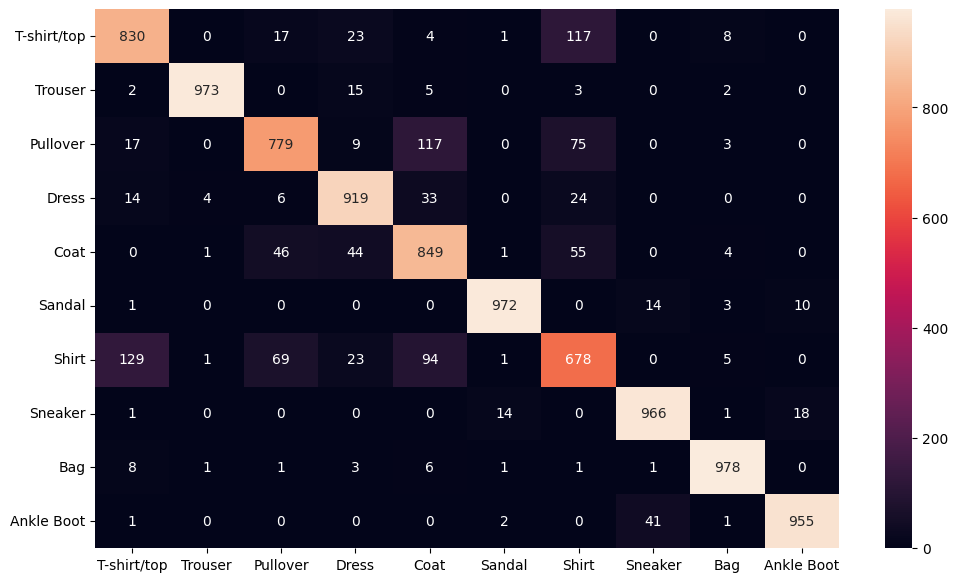

In [28]:
correct3 = 0
total3 = 0
y_pred_3 = []
y_true_3 = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net3(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total3 += labels.size(0)
        correct3 += (predicted == labels).sum().item()
        y_pred_3.extend(predicted.data.cpu().numpy())
        y_true_3.extend(labels.data.cpu().numpy())
print(f'Accuracy of the network on the 10000 test images: {100 * correct3 // total3} %')

cf_matrix_3 = confusion_matrix(y_true_3, y_pred_3)

cf_matrix_dataframe_3 = pd.DataFrame(cf_matrix_3, index = [i for i in classes],
                     columns = [i for i in classes])

# Dummy input for graph, requires_grad = True to see full visualization
graph_random_input = torch.randn(1, 1, 28, 28, requires_grad=True)
# Dummy output for graph
graph_random_output = net3(graph_random_input)
make_dot(graph_random_output, params=dict(list(net3.named_parameters()))).render("net_graph3", format="png")

plt.figure(figsize = (12,7))
sns.heatmap(cf_matrix_dataframe_3, annot=True, fmt='g')